#Fragestellug
Welcher der Ansätze ist am besten (klassisch/knn)? <br>



In [1]:
%%capture
!pip install -U spacy
!python -m spacy download de_core_news_lg
!pip install xlsxwriter

In [2]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import itertools
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, LSTM, SimpleRNN, GRU, Dropout, Activation, Embedding, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D,MaxPooling1D, Conv1D,concatenate,Concatenate
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import statistics
from statistics import mean, stdev
import spacy
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import xlsxwriter
from keras.initializers import Constant
from gensim.models import KeyedVectors
import random
import xlsxwriter
import sklearn as sk
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression

#Setup

In [3]:
###############  Hyperparameter definieren   ######################
randomstate = 41
#Textaufbereitung
vocab_size = 10000
max_length_kurz = 120
max_length_lang = 390
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # OOV = Out of Vocabulary

#Cross Validation
splits = 10
kfold = StratifiedKFold(n_splits=splits,shuffle=True, random_state=randomstate)

#Modell
embedding_dim = 300
batch_size = 20
no_epochs = 10
verbosity = 0

class_names = ['A1','A2','B1','B2','C']

##Funktionen

In [4]:
def convert_to_one_hot(_fitdata,_transformdata):
  from sklearn.preprocessing import LabelEncoder
  from keras.utils import np_utils
  #Lable in Zahlen umwandeln
  encoder = LabelEncoder()
  encoder.fit(_fitdata)
  encoded_data = encoder.transform(_transformdata)
  #Zahlen in One Hot Vektoren umwandeln
  one_hot_vectors = np_utils.to_categorical(encoded_data)
  return [one_hot_vectors,encoder]

def convert_to_int(_transformdata):
  #Labels in Zahlen umwandeln
  label_tokenizer = Tokenizer(lower=False)
  label_tokenizer.word_index = {'A1': 1,'A2': 2,'B1': 3,'B2':4,'C':5}
  label_sequence = np.array(label_tokenizer.texts_to_sequences(l_labels))
  return [label_sequence, label_tokenizer]

def convert_to_label(_transformdata):
  #Labels in Zahlen umwandeln
  label_tokenizer = Tokenizer(lower=False)
  label_tokenizer.word_index = {1: 'A1', 2: 'A2',3: 'B1',4:'B2',5:'C'}
  label_sequence = np.array(label_tokenizer.texts_to_sequences(l_labels))
  return label_sequence

def model_evaluation_classification(_x_test, _y_test, _encoder):
  y_pred = model.predict(_x_test)
  y_pred = np.argmax(y_pred, axis=1)
  y_pred = _encoder.inverse_transform(y_pred)
  y_true = _y_test
  kappa = cohen_kappa_score(y_true,y_pred,weights='quadratic')  
  acc = accuracy_score(y_true,y_pred)*100
  conf = confusion_matrix(y_true, y_pred,labels=['A1','A2','B1','B2','C'])
  return {'accuracy': acc, 'kappa score': kappa, 'confusion matrix':conf,}

def model_evaluation_regression(_x_test, _y_test):
  y_pred = model.predict(_x_test)
  y_pred = np.clip(np.rint(y_pred), 0, 5)
  #y_pred = _encoder.inverse_transform(y_pred)
  y_true = _y_test
  kappa = cohen_kappa_score(y_true,y_pred,weights='quadratic')  
  acc = accuracy_score(y_true,y_pred)*100
  conf = confusion_matrix(y_true, y_pred,labels=[1,2,3,4,5])
  return {'accuracy': acc, 'kappa score': kappa, 'confusion matrix':conf,}

def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Richtige Niveaustufe')
    plt.xlabel('Vorhergesagte Niveaustufe')

    return cnf_matrix

################# Funktion zum Trainieren und evaluieren #####################
def evaluate_model(_input=None, _target=None, _approach='klassisch_re'):
  _approaches = ['klassisch_cl','klassisch_re', 'knn']
  if _approach not in _approaches:
    raise ValueError("Invalid sim type. Expected one of: %s" % _approach)

  predicted_targets = np.array([])
  true_targets = np.array([])
  acc_per_fold = []
  kappa_per_fold = []
  for train, test in kfold.split(_input, _target):   
    x_train = _input[train]
    x_test = _input[test]
    y_train = _target[train]
    y_test = _target[test]

    if _approach == 'klassisch_cl' or _approach == 'klassisch_re':
      model = svm
      y_train = np.where(y_train=='A1', 1.0, y_train)
      y_train = np.where(y_train=='A2', 2.0, y_train)
      y_train = np.where(y_train=='B1', 3.0, y_train)
      y_train = np.where(y_train=='B2', 4.0, y_train)
      y_train = np.where(y_train=='C', 5.0, y_train)

    if _approach == 'knn':
      model = normal_knn_model()

    if _approach == 'knn':
      #Zielvariablen in One Hot Repräsentation umwandeln
      one_hot = convert_to_one_hot(_target,y_train)
      encoder = one_hot[1]
      y_train = one_hot[0]
    
    #Modell trainieren
    if _approach == 'knn':
      model.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity)
      
    elif _approach == 'klassisch_cl' or _approach == 'klassisch_re':
      model.fit(x_train,y_train)


    #Vorhersagen treffen
    predicted_labels = model.predict(x_test)

    if _approach == 'knn':
      #One Hot wieder in Labels umwandeln
      predicted_labels = np.argmax(predicted_labels, axis=1)
      predicted_labels = encoder.inverse_transform(predicted_labels)

    elif _approach == 'klassisch_re':
      predicted_labels = np.clip(np.rint(predicted_labels),0,5)
      predicted_labels = np.where(predicted_labels==1.0, 'A1', predicted_labels)
      predicted_labels = np.where(predicted_labels=='2.0', 'A2', predicted_labels)
      predicted_labels = np.where(predicted_labels=='3.0', 'B1', predicted_labels)
      predicted_labels = np.where(predicted_labels=='4.0', 'B2', predicted_labels)
      predicted_labels = np.where(predicted_labels=='5.0', 'C', predicted_labels)
    elif _approach == 'klassisch_cl':
      #predicted_labels = np.clip(np.rint(predicted_labels),0,5)
      predicted_labels = np.where(predicted_labels=='1.0', 'A1', predicted_labels)
      predicted_labels = np.where(predicted_labels=='2.0', 'A2', predicted_labels)
      predicted_labels = np.where(predicted_labels=='3.0', 'B1', predicted_labels)
      predicted_labels = np.where(predicted_labels=='4.0', 'B2', predicted_labels)
      predicted_labels = np.where(predicted_labels=='5.0', 'C', predicted_labels)

    predicted_targets= np.append(predicted_targets, predicted_labels)
    true_targets = np.append(true_targets, y_test)

    #Metriken berechnen


    kappa = cohen_kappa_score(y_test,predicted_labels,weights='quadratic')  
    acc = accuracy_score(y_test,predicted_labels)*100
    kappa_per_fold.append(kappa)
    acc_per_fold.append(acc)
  acc = mean(acc_per_fold)
  kappa = mean(kappa_per_fold)
  return predicted_targets, true_targets, acc, kappa



#Texte und Label aufbereiten

In [5]:
labels = pd.read_excel('/content/drive/MyDrive/Masterarbeit/Data/metadaten.xlsx', index_col=0)
texts = pd.read_excel('/content/drive/MyDrive/Masterarbeit/Data/texts.xlsx',index_col=0)

In [6]:
labels.sort_values(by=['id'],inplace=True)
texts.sort_values(by=['id'],inplace=True)

In [7]:
labels.cerf_rating.replace(['A2','A2+'],'A2', inplace=True)
labels.cerf_rating.replace(['B1','B1+'],'B1', inplace=True)
labels.cerf_rating.replace(['B2','B2+'],'B2', inplace=True)
labels.cerf_rating.replace(['C1','C2'],'C', inplace=True)

In [8]:
l_labels = labels['cerf_rating'].to_list()
l_texts = texts['text'].to_list()

In [9]:
################ Labels aufbereiten #########################
target = np.array(l_labels)

In [10]:
################ Texte aufbereiten #########################

#Vokabular mit Tokenizer erstellen
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok, )
tokenizer.fit_on_texts(l_texts)
word_index = tokenizer.word_index

#####Texte in integer umwandeln und auf einheiliche Länge bringen
###Texte auf 120 bringen
text_sequences = tokenizer.texts_to_sequences(l_texts)
input_text_kurz = pad_sequences(text_sequences, maxlen=max_length_kurz, padding=padding_type, truncating=trunc_type)
###Texte auf 390 bringen
text_sequences = tokenizer.texts_to_sequences(l_texts)
input_text_lang = pad_sequences(text_sequences, maxlen=max_length_lang, padding=padding_type, truncating=trunc_type)

#Feature aufbereiten

In [11]:
data = pd.read_excel('/content/drive/MyDrive/Masterarbeit/Data/features.xlsx', index_col=0)  

In [12]:
all_features = data.drop(columns=['cerf_rating','lex_ttr','lex_verb_var_1','lex_sqrt_verb_var_1','lex_cor_verb_var_1','lex_wiener_sachtextformel','morph_first_person_fin_verb_ratio'])

In [19]:
#Featureset mit niedriger korrelation (-0.5 >= r <= 0.5) erstellen
corr = all_features.drop(columns=['shal_text_length']).corrwith(all_features['shal_text_length'],axis=0,method='pearson',)
all_features = all_features.drop(columns=['shal_text_length'])
low_corr = []
for index in corr.index:
  if corr[index] >= -0.5 and corr[index] <= 0.5:
    low_corr.append(index)

low_corr_features = all_features[low_corr]

In [14]:
low_corr_features

,lex_hdd,lex_mtld,lex_adverb_var,lex_modifier_var,lex_noun_var,lex_verb_var_2,er_avg_num_errors,dep_per_noun,dep_per_verb,syn_avg_len_clause,syn_avg_nonterminals_per_sent,syn_avg_tunit_length,syn_avg_vz_per_sent,syn_avg_corinate_phrases_per_sent,lex_yules_k,lex_uber_index,shal_chars_per_word,shal_syl_per_word,morph_comp_noun_ratio,morph_first_person_verb_ratio,morph_second_person_verb_ratio,morph_third_person_verb_ratio,morph_past_tense_verb_ratio,morph_past_participle_verb_ratio,morph_nominative_nouns_ratio,morph_genitiv_nouns_ratio,morph_dativ_nouns_ratio,morph_akkusativ_nouns_ratio,morph_singular_nouns_ratio,morph_plural_nouns_ratio,morph_keit_suffix_ratio,morph_ung_suffix_ratio,morph_werk_suffix_ratio
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1023_0001416,0.783363,43.956186,0.071429,0.261905,0.428571,0.238095,0.722222,1.375000,2.923077,6.3600,21.4000,8.8333,0.2000,0.3333,93.6884,86.0749,5.913043,1.950311,0.325000,1.038462,0.000000,0.423077,0.961538,0.153846,0.350000,0.025000,0.275000,0.350000,1.975000,0.725000,0.050000,0.100000,0.0
1023_0001418,0.800869,53.645573,0.054795,0.164384,0.410959,0.301370,1.150000,1.281250,2.555556,7.2174,19.9375,8.7368,0.0000,0.3750,106.3355,71.5175,5.708333,1.934524,0.156250,0.900000,0.000000,0.400000,0.833333,0.100000,0.281250,0.031250,0.156250,0.500000,2.625000,0.937500,0.000000,0.062500,0.0
1023_0001419,0.806800,57.793976,0.064935,0.246753,0.350649,0.298701,0.937500,1.222222,2.333333,7.3636,24.6923,8.5263,1.0000,0.3077,93.3606,83.0995,5.926380,1.975460,0.296296,0.812500,0.000000,0.375000,0.750000,0.000000,0.148148,0.000000,0.259259,0.592593,2.629630,1.111111,0.000000,0.111111,0.0
1023_0001420,0.788381,47.501553,0.095890,0.178082,0.397260,0.342466,0.944444,0.969697,2.826087,6.5357,25.0000,8.3182,0.3333,0.2857,122.0964,61.9366,5.572973,1.864865,0.303030,1.088235,0.000000,0.382353,0.911765,0.058824,0.242424,0.030303,0.242424,0.454545,2.606061,0.909091,0.030303,0.060606,0.0
1023_0001422,0.854652,74.659968,0.083333,0.142857,0.488095,0.226190,0.978723,1.021277,2.733333,9.5238,30.4615,12.5000,0.0000,0.3077,90.8071,73.0191,5.477833,1.793103,0.255319,0.833333,0.000000,0.333333,0.916667,0.000000,0.425532,0.021277,0.255319,0.319149,2.468085,0.404255,0.000000,0.021277,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091_0000272,0.757471,43.440156,0.034483,0.103448,0.275862,0.310345,0.846154,1.090909,2.666667,4.5385,11.6364,4.9167,0.0000,0.0000,86.1821,66.8002,4.793651,1.523810,0.636364,0.538462,0.230769,0.615385,0.769231,0.076923,0.454545,0.090909,0.181818,0.363636,3.727273,0.090909,0.000000,0.000000,0.0
1091_0000273,0.797920,77.000000,0.230769,0.230769,0.346154,0.384615,0.444444,1.416667,2.666667,5.9091,15.6250,7.2222,0.0000,0.0000,141.0935,63.1241,4.776119,1.537313,0.333333,0.785714,0.357143,0.285714,0.928571,0.071429,0.250000,0.000000,0.333333,0.416667,3.750000,0.000000,0.000000,0.000000,0.0
1091_0000274,0.768549,42.117647,0.000000,0.055556,0.333333,0.361111,1.214286,1.214286,2.600000,4.7059,14.8333,5.3333,0.0000,0.0833,140.6250,59.7112,4.523810,1.547619,0.428571,1.000000,0.157895,0.368421,0.789474,0.105263,0.357143,0.000000,0.142857,0.571429,4.214286,0.214286,0.000000,0.000000,0.0


In [15]:
len(low_corr_features.columns)

33

In [21]:
len(all_features.columns)

43

In [22]:
#Features normalisieren [0,1]
scaler = MinMaxScaler(feature_range=(0,1))
input_ling_33 = scaler.fit_transform(low_corr_features)
input_ling_43 = scaler.fit_transform(all_features)


#Modelle definieren

In [17]:
#normal knn
def normal_knn_model():
  #Modell definieren
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim))
  model.add(GRU(embedding_dim,return_sequences=True))
  model.add(GlobalAveragePooling1D())
  model.add(Dense(5, activation='softmax'))

  #Modell kompilieren
  opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
  model.compile(
      loss='categorical_crossentropy',
      optimizer=opt,
      metrics=['accuracy',],
  )
  return model

In [18]:
#klassisch (Support Vector Klassifikation)
svm = RandomForestClassifier(random_state=randomstate)

#klassisch

##reduziertes Feautreset

Confusion matrix, without normalization


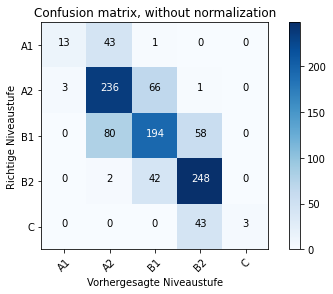

Normalized confusion matrix


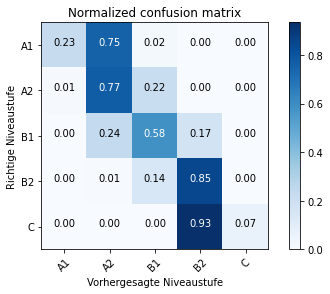

In [26]:
##### RFK reduziertes Feature-Set
great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])

predicted_targets, true_targets, acc, kappa = evaluate_model(input_ling_33, target,'klassisch_cl')
great_acc.append(acc)
great_kappa.append(kappa)
all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
all_true_targets = np.append(all_true_targets, true_targets)

klassisch_33 = {'name': 'RFK + 33 Features',
             'acc':mean(great_acc),
             #'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             #'qwk_std':stdev(great_kappa)
             }
plot_confusion_matrix(all_predicted_targets, all_true_targets)

##gesamtes Feature_set

Confusion matrix, without normalization


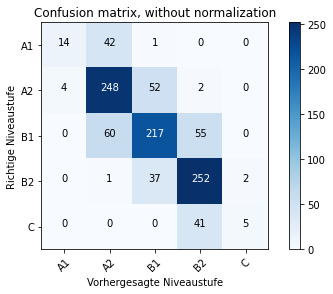

Normalized confusion matrix


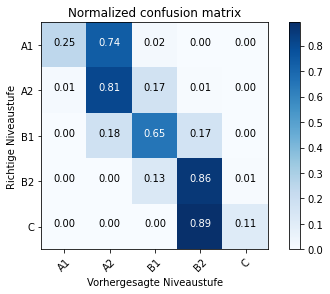

In [27]:
##### RFK gesamtes Feature-Set
great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])

predicted_targets, true_targets, acc, kappa = evaluate_model(input_ling_43, target,'klassisch_cl')
great_acc.append(acc)
great_kappa.append(kappa)
all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
all_true_targets = np.append(all_true_targets, true_targets)

klassisch_43 = {'name': 'RFK + 43 Features',
             'acc':mean(great_acc),
             #'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             #'qwk_std':stdev(great_kappa)
             }
plot_confusion_matrix(all_predicted_targets, all_true_targets)

In [28]:
results = pd.DataFrame([klassisch_33,klassisch_43] ,columns=['name','acc','qwk'])
results.sort_values('qwk')

,name,acc,qwk
0,RFK + 33 Features,67.179798,0.803959
1,RFK + 43 Features,71.248133,0.828446


In [29]:
results.to_excel('/content/drive/MyDrive/Masterarbeit/Data/best_model_klassisch.xlsx', engine='xlsxwriter', index=False)  

#neuronal

##gekürzte Texte

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0799 - accuracy: 0.5823
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7624 - accuracy: 0.6857
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5488 - accuracy: 0.7610
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3131 - accuracy: 0.8924
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1848 - accuracy: 0.9537
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0972 - accuracy: 0.9720
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0534 - accuracy: 0.9860
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0313 - accuracy: 0.9946
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0612 - accuracy: 0.9828
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0277 - accuracy: 0.9968
Epoch 1/1

  1%|          | 1/100 [02:20<3:51:13, 140.14s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1023 - accuracy: 0.5522
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7733 - accuracy: 0.6900
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5771 - accuracy: 0.7740
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3433 - accuracy: 0.8751
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1991 - accuracy: 0.9386
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1137 - accuracy: 0.9731
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0440 - accuracy: 0.9882
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0164 - accuracy: 0.9978
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0273 - accuracy: 0.9946
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0454 - accuracy: 0.9882
Epoch 1/1

  2%|▏         | 2/100 [03:52<3:02:41, 111.85s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.0541 - accuracy: 0.5931
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7463 - accuracy: 0.6954
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5361 - accuracy: 0.7944
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3449 - accuracy: 0.8773
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1692 - accuracy: 0.9526
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0824 - accuracy: 0.9785
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0469 - accuracy: 0.9903
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0249 - accuracy: 0.9935
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0340 - accuracy: 0.9935
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0271 - accuracy: 0.9957
Epoch 1/1

  3%|▎         | 3/100 [05:39<2:57:42, 109.92s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.0753 - accuracy: 0.5867
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7354 - accuracy: 0.7008
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5367 - accuracy: 0.7869
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3889 - accuracy: 0.8547
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1797 - accuracy: 0.9397
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1235 - accuracy: 0.9688
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0568 - accuracy: 0.9892
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0264 - accuracy: 0.9925
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0360 - accuracy: 0.9925
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0097 - accuracy: 0.9989
Epoch 1/1

  4%|▍         | 4/100 [07:16<2:47:38, 104.77s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0688 - accuracy: 0.5770
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7634 - accuracy: 0.6814
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5608 - accuracy: 0.7858
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3837 - accuracy: 0.8644
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1881 - accuracy: 0.9386
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0978 - accuracy: 0.9785
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0463 - accuracy: 0.9882
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0487 - accuracy: 0.9849
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0199 - accuracy: 0.9989
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 1/1

  5%|▌         | 5/100 [08:59<2:44:32, 103.92s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.0446 - accuracy: 0.5802
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7635 - accuracy: 0.6889
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5351 - accuracy: 0.7944
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3540 - accuracy: 0.8719
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1773 - accuracy: 0.9526
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0759 - accuracy: 0.9785
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0264 - accuracy: 0.9968
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0160 - accuracy: 0.9989
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0138 - accuracy: 0.9968
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0763 - accuracy: 0.9785
Epoch 1/1

  6%|▌         | 6/100 [10:45<2:44:20, 104.90s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1152 - accuracy: 0.5188
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7624 - accuracy: 0.6997
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5800 - accuracy: 0.7804
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3993 - accuracy: 0.8590
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2114 - accuracy: 0.9376
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1036 - accuracy: 0.9709
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0544 - accuracy: 0.9839
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0231 - accuracy: 0.9935
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0188 - accuracy: 0.9946
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 1/1

  7%|▋         | 7/100 [12:37<2:46:08, 107.19s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0639 - accuracy: 0.5974
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7648 - accuracy: 0.6889
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5712 - accuracy: 0.7675
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3432 - accuracy: 0.8848
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1770 - accuracy: 0.9462
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0868 - accuracy: 0.9677
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0373 - accuracy: 0.9935
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0270 - accuracy: 0.9935
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0571 - accuracy: 0.9849
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0130 - accuracy: 0.9989
Epoch 1/1

  8%|▊         | 8/100 [14:10<2:37:20, 102.62s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.0857 - accuracy: 0.5673
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7486 - accuracy: 0.7040
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5430 - accuracy: 0.7804
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3411 - accuracy: 0.8881
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1629 - accuracy: 0.9526
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0995 - accuracy: 0.9795
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0343 - accuracy: 0.9935
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0342 - accuracy: 0.9925
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0266 - accuracy: 0.9957
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0134 - accuracy: 0.9978
Epoch 1/1

  9%|▉         | 9/100 [15:38<2:28:41, 98.04s/it] 

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.0815 - accuracy: 0.5651
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7574 - accuracy: 0.6814
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5972 - accuracy: 0.7610
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3554 - accuracy: 0.8708
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1739 - accuracy: 0.9494
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0770 - accuracy: 0.9806
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0355 - accuracy: 0.9946
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0230 - accuracy: 0.9989
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0070 - accuracy: 1.0000
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 1/1

 10%|█         | 10/100 [17:16<2:26:52, 97.92s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1434 - accuracy: 0.5457
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7647 - accuracy: 0.6964
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5654 - accuracy: 0.7664
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3387 - accuracy: 0.8881
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1730 - accuracy: 0.9505
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1120 - accuracy: 0.9645
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0608 - accuracy: 0.9871
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0274 - accuracy: 0.9935
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0220 - accuracy: 0.9946
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0257 - accuracy: 0.9925
Epoch 1/1

 11%|█         | 11/100 [19:08<2:31:40, 102.25s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.0660 - accuracy: 0.5651
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7684 - accuracy: 0.6889
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5759 - accuracy: 0.7653
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3747 - accuracy: 0.8741
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1730 - accuracy: 0.9408
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0737 - accuracy: 0.9785
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0413 - accuracy: 0.9925
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0547 - accuracy: 0.9871
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0454 - accuracy: 0.9882
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0140 - accuracy: 0.9978
Epoch 1/1

 12%|█▏        | 12/100 [20:36<2:23:43, 97.99s/it] 

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.0486 - accuracy: 0.5931
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7544 - accuracy: 0.6900
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5518 - accuracy: 0.7750
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2878 - accuracy: 0.8988
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1523 - accuracy: 0.9494
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0912 - accuracy: 0.9763
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0490 - accuracy: 0.9892
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0162 - accuracy: 1.0000
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0075 - accuracy: 0.9989
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0110 - accuracy: 0.9968
Epoch 1/1

 13%|█▎        | 13/100 [22:14<2:22:03, 97.97s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.0718 - accuracy: 0.5791
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7592 - accuracy: 0.6835
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5840 - accuracy: 0.7600
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3968 - accuracy: 0.8633
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1945 - accuracy: 0.9386
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1002 - accuracy: 0.9742
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0565 - accuracy: 0.9871
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0222 - accuracy: 0.9957
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0122 - accuracy: 0.9989
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 1/1

 14%|█▍        | 14/100 [23:47<2:18:19, 96.50s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0863 - accuracy: 0.5791
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7549 - accuracy: 0.6857
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6064 - accuracy: 0.7546
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3568 - accuracy: 0.8805
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.2048 - accuracy: 0.9408
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1233 - accuracy: 0.9559
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0674 - accuracy: 0.9839
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0347 - accuracy: 0.9957
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0131 - accuracy: 0.9989
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 1/1

 15%|█▌        | 15/100 [25:20<2:15:19, 95.52s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1013 - accuracy: 0.5597
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7588 - accuracy: 0.6932
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5893 - accuracy: 0.7621
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3613 - accuracy: 0.8676
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1669 - accuracy: 0.9429
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0954 - accuracy: 0.9731
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0808 - accuracy: 0.9806
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0475 - accuracy: 0.9882
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0152 - accuracy: 0.9978
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 1/1

 16%|█▌        | 16/100 [26:54<2:12:47, 94.85s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0823 - accuracy: 0.5780
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7724 - accuracy: 0.6868
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6062 - accuracy: 0.7492
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3517 - accuracy: 0.8719
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1923 - accuracy: 0.9462
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0855 - accuracy: 0.9763
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0379 - accuracy: 0.9935
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0178 - accuracy: 0.9968
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0115 - accuracy: 0.9978
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0231 - accuracy: 0.9946
Epoch 1/1

 17%|█▋        | 17/100 [28:37<2:14:34, 97.28s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.0981 - accuracy: 0.5813
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7734 - accuracy: 0.6781
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5818 - accuracy: 0.7696
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3513 - accuracy: 0.8687
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1647 - accuracy: 0.9483
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0880 - accuracy: 0.9785
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0395 - accuracy: 0.9946
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0234 - accuracy: 0.9935
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0284 - accuracy: 0.9968
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0222 - accuracy: 0.9946
Epoch 1/1

 18%|█▊        | 18/100 [30:05<2:09:30, 94.76s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0689 - accuracy: 0.5813
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7398 - accuracy: 0.6900
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5513 - accuracy: 0.7729
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3776 - accuracy: 0.8558
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1965 - accuracy: 0.9333
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1328 - accuracy: 0.9666
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0813 - accuracy: 0.9806
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0294 - accuracy: 0.9935
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0163 - accuracy: 0.9968
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0072 - accuracy: 1.0000
Epoch 1/1

 19%|█▉        | 19/100 [31:44<2:09:21, 95.82s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0931 - accuracy: 0.5501
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7754 - accuracy: 0.6889
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5981 - accuracy: 0.7567
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3754 - accuracy: 0.8644
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1902 - accuracy: 0.9376
Epoch 6/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0843 - accuracy: 0.9785
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0368 - accuracy: 0.9946
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0359 - accuracy: 0.9903
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0282 - accuracy: 0.9935
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0309 - accuracy: 0.9946
Epoch 1/1

 20%|██        | 20/100 [33:03<2:01:13, 90.92s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.0717 - accuracy: 0.5823
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7802 - accuracy: 0.6954
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5801 - accuracy: 0.7729
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3374 - accuracy: 0.8816
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1834 - accuracy: 0.9419
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1194 - accuracy: 0.9634
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0952 - accuracy: 0.9763
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0176 - accuracy: 1.0000
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 1/1

 21%|██        | 21/100 [34:41<2:02:27, 93.00s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.0614 - accuracy: 0.5748
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7396 - accuracy: 0.7029
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5477 - accuracy: 0.7912
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3362 - accuracy: 0.8751
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1915 - accuracy: 0.9397
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0929 - accuracy: 0.9806
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0635 - accuracy: 0.9860
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0170 - accuracy: 0.9989
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0219 - accuracy: 0.9925
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0220 - accuracy: 0.9946
Epoch 1/1

 22%|██▏       | 22/100 [36:24<2:04:45, 95.97s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0325 - accuracy: 0.6028
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7335 - accuracy: 0.6932
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5988 - accuracy: 0.7653
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3960 - accuracy: 0.8741
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2388 - accuracy: 0.9257
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0998 - accuracy: 0.9720
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0439 - accuracy: 0.9882
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0275 - accuracy: 0.9957
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0212 - accuracy: 0.9968
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 1/1

 23%|██▎       | 23/100 [38:03<2:04:10, 96.75s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.0515 - accuracy: 0.5737
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7476 - accuracy: 0.6911
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5706 - accuracy: 0.7696
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3561 - accuracy: 0.8794
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1669 - accuracy: 0.9473
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1115 - accuracy: 0.9688
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0873 - accuracy: 0.9709
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0334 - accuracy: 0.9935
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0112 - accuracy: 0.9989
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0057 - accuracy: 1.0000
Epoch 1/1

 24%|██▍       | 24/100 [39:51<2:06:47, 100.10s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0655 - accuracy: 0.5501
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7940 - accuracy: 0.6695
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.6326 - accuracy: 0.7384
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4457 - accuracy: 0.8267
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2063 - accuracy: 0.9311
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1025 - accuracy: 0.9752
Epoch 7/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0697 - accuracy: 0.9882
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0523 - accuracy: 0.9925
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0170 - accuracy: 0.9978
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0072 - accuracy: 1.0000
Epoch 1/1

 25%|██▌       | 25/100 [41:24<2:02:39, 98.13s/it] 

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.1031 - accuracy: 0.5447
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7539 - accuracy: 0.6771
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5631 - accuracy: 0.7707
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3356 - accuracy: 0.8913
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2103 - accuracy: 0.9429
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0880 - accuracy: 0.9817
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0347 - accuracy: 0.9935
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0310 - accuracy: 0.9925
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0411 - accuracy: 0.9882
Epoch 10/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0233 - accuracy: 0.9957
Epoch 1/1

 26%|██▌       | 26/100 [42:58<1:59:19, 96.75s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0616 - accuracy: 0.5780
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7411 - accuracy: 0.6975
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6027 - accuracy: 0.7567
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3944 - accuracy: 0.8568
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1977 - accuracy: 0.9354
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0808 - accuracy: 0.9828
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0559 - accuracy: 0.9882
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0315 - accuracy: 0.9957
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0088 - accuracy: 1.0000
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 1/1

 27%|██▋       | 27/100 [44:41<2:00:11, 98.79s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1046 - accuracy: 0.5823
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7605 - accuracy: 0.6954
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5457 - accuracy: 0.7793
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3482 - accuracy: 0.8805
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1695 - accuracy: 0.9591
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0625 - accuracy: 0.9839
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0368 - accuracy: 0.9925
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0351 - accuracy: 0.9903
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0487 - accuracy: 0.9849
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0417 - accuracy: 0.9892
Epoch 1/1

 28%|██▊       | 28/100 [46:15<1:56:43, 97.27s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0642 - accuracy: 0.5565
Epoch 2/10
47/47 [==============================] - 1s 11ms/step - loss: 0.7779 - accuracy: 0.6825
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6461 - accuracy: 0.7330
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3616 - accuracy: 0.8558
Epoch 5/10
47/47 [==============================] - 1s 11ms/step - loss: 0.1854 - accuracy: 0.9473
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1279 - accuracy: 0.9580
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0617 - accuracy: 0.9903
Epoch 8/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0165 - accuracy: 0.9989
Epoch 9/10
47/47 [==============================] - 1s 11ms/step - loss: 0.0079 - accuracy: 1.0000
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0260 - accuracy: 0.9925
Epoch 1/1

 29%|██▉       | 29/100 [47:58<1:57:15, 99.09s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0839 - accuracy: 0.5597
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7261 - accuracy: 0.7094
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5572 - accuracy: 0.7761
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3675 - accuracy: 0.8547
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1724 - accuracy: 0.9526
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0661 - accuracy: 0.9828
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1296 - accuracy: 0.9645
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0430 - accuracy: 0.9935
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0109 - accuracy: 0.9989
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0325 - accuracy: 0.9914
Epoch 1/1

 30%|███       | 30/100 [49:28<1:52:18, 96.26s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0686 - accuracy: 0.5867
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7393 - accuracy: 0.6997
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5220 - accuracy: 0.7933
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3512 - accuracy: 0.8665
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1967 - accuracy: 0.9408
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0769 - accuracy: 0.9785
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0467 - accuracy: 0.9925
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0147 - accuracy: 1.0000
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0166 - accuracy: 0.9968
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0120 - accuracy: 0.9978
Epoch 1/1

 31%|███       | 31/100 [51:11<1:53:06, 98.35s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0844 - accuracy: 0.5931
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7651 - accuracy: 0.6857
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5516 - accuracy: 0.7686
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3662 - accuracy: 0.8665
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2048 - accuracy: 0.9429
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1047 - accuracy: 0.9677
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0412 - accuracy: 0.9914
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0396 - accuracy: 0.9914
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0132 - accuracy: 0.9989
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0274 - accuracy: 0.9935
Epoch 1/1

 32%|███▏      | 32/100 [52:54<1:53:09, 99.84s/it]

Epoch 1/10
47/47 [==============================] - 2s 11ms/step - loss: 1.0611 - accuracy: 0.5382
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7653 - accuracy: 0.6900
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5720 - accuracy: 0.7804
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3483 - accuracy: 0.8773
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1548 - accuracy: 0.9559
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0667 - accuracy: 0.9839
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0452 - accuracy: 0.9914
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0249 - accuracy: 0.9957
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0410 - accuracy: 0.9882
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0148 - accuracy: 0.9968
Epoch 1/1

 33%|███▎      | 33/100 [54:42<1:54:14, 102.30s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0958 - accuracy: 0.5813
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7421 - accuracy: 0.6943
Epoch 3/10
47/47 [==============================] - 1s 11ms/step - loss: 0.5882 - accuracy: 0.7740
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3899 - accuracy: 0.8568
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2132 - accuracy: 0.9268
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0940 - accuracy: 0.9742
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0423 - accuracy: 0.9935
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0231 - accuracy: 0.9978
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0177 - accuracy: 0.9957
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0322 - accuracy: 0.9903
Epoch 1/1

 34%|███▍      | 34/100 [56:17<1:49:56, 99.94s/it] 

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1014 - accuracy: 0.5770
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7592 - accuracy: 0.6921
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5579 - accuracy: 0.7740
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3277 - accuracy: 0.8805
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1810 - accuracy: 0.9516
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0874 - accuracy: 0.9752
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0426 - accuracy: 0.9925
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0433 - accuracy: 0.9892
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0425 - accuracy: 0.9882
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0180 - accuracy: 0.9978
Epoch 1/1

 35%|███▌      | 35/100 [57:51<1:46:28, 98.29s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0706 - accuracy: 0.5651
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7632 - accuracy: 0.6975
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5472 - accuracy: 0.7955
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3262 - accuracy: 0.8881
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2121 - accuracy: 0.9354
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0788 - accuracy: 0.9806
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0419 - accuracy: 0.9914
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0164 - accuracy: 0.9978
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0248 - accuracy: 0.9957
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0153 - accuracy: 0.9957
Epoch 1/1

 36%|███▌      | 36/100 [59:22<1:42:18, 95.91s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0026 - accuracy: 0.5963
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7221 - accuracy: 0.6986
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5534 - accuracy: 0.7535
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3854 - accuracy: 0.8762
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1696 - accuracy: 0.9494
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1276 - accuracy: 0.9666
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0824 - accuracy: 0.9871
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0381 - accuracy: 0.9935
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0075 - accuracy: 1.0000
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 1/1

 37%|███▋      | 37/100 [1:01:15<1:46:04, 101.02s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0831 - accuracy: 0.5899
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7564 - accuracy: 0.6921
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5294 - accuracy: 0.7869
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3573 - accuracy: 0.8590
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1824 - accuracy: 0.9429
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0786 - accuracy: 0.9742
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0566 - accuracy: 0.9903
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0804 - accuracy: 0.9785
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0291 - accuracy: 0.9935
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0056 - accuracy: 1.0000
Epoch 1/1

 38%|███▊      | 38/100 [1:02:58<1:45:14, 101.84s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0502 - accuracy: 0.5770
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7287 - accuracy: 0.6921
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5464 - accuracy: 0.7826
Epoch 4/10
47/47 [==============================] - 1s 11ms/step - loss: 0.3635 - accuracy: 0.8730
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1997 - accuracy: 0.9376
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1271 - accuracy: 0.9623
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0422 - accuracy: 0.9903
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0588 - accuracy: 0.9817
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0575 - accuracy: 0.9914
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0109 - accuracy: 1.0000
Epoch 1/1

 39%|███▉      | 39/100 [1:04:38<1:42:49, 101.14s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0439 - accuracy: 0.6039
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7627 - accuracy: 0.6749
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5660 - accuracy: 0.7772
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3410 - accuracy: 0.8977
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1562 - accuracy: 0.9548
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0982 - accuracy: 0.9709
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0635 - accuracy: 0.9849
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0282 - accuracy: 0.9968
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0093 - accuracy: 0.9989
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0098 - accuracy: 0.9978
Epoch 1/1

 40%|████      | 40/100 [1:06:13<1:39:15, 99.26s/it] 

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0665 - accuracy: 0.5867
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7271 - accuracy: 0.6964
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5308 - accuracy: 0.7890
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3333 - accuracy: 0.8891
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1679 - accuracy: 0.9473
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0853 - accuracy: 0.9785
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0475 - accuracy: 0.9903
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0345 - accuracy: 0.9925
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0313 - accuracy: 0.9914
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0427 - accuracy: 0.9892
Epoch 1/1

 41%|████      | 41/100 [1:07:48<1:36:17, 97.93s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0889 - accuracy: 0.5576
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7698 - accuracy: 0.6814
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5628 - accuracy: 0.7761
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3335 - accuracy: 0.8881
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1622 - accuracy: 0.9494
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0696 - accuracy: 0.9860
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0477 - accuracy: 0.9860
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0381 - accuracy: 0.9903
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0249 - accuracy: 0.9935
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0225 - accuracy: 0.9957
Epoch 1/1

 42%|████▏     | 42/100 [1:09:23<1:33:49, 97.06s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0894 - accuracy: 0.5501
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7624 - accuracy: 0.6781
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5901 - accuracy: 0.7427
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3674 - accuracy: 0.8719
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1939 - accuracy: 0.9440
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0986 - accuracy: 0.9709
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0428 - accuracy: 0.9935
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0266 - accuracy: 0.9957
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0141 - accuracy: 0.9989
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0099 - accuracy: 0.9978
Epoch 1/1

 43%|████▎     | 43/100 [1:11:02<1:32:53, 97.78s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1131 - accuracy: 0.5533
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7551 - accuracy: 0.6911
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5715 - accuracy: 0.7621
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3344 - accuracy: 0.8881
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1736 - accuracy: 0.9451
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0798 - accuracy: 0.9828
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0460 - accuracy: 0.9892
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0176 - accuracy: 0.9978
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0172 - accuracy: 0.9968
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0084 - accuracy: 1.0000
Epoch 1/1

 44%|████▍     | 44/100 [1:12:46<1:33:01, 99.67s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1295 - accuracy: 0.5296
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7995 - accuracy: 0.6943
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5805 - accuracy: 0.7632
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3732 - accuracy: 0.8708
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1772 - accuracy: 0.9559
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0865 - accuracy: 0.9828
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0266 - accuracy: 0.9978
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0192 - accuracy: 0.9978
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0629 - accuracy: 0.9752
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0338 - accuracy: 0.9925
Epoch 1/1

 45%|████▌     | 45/100 [1:14:26<1:31:21, 99.66s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1192 - accuracy: 0.5490
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7515 - accuracy: 0.6792
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5898 - accuracy: 0.7546
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3441 - accuracy: 0.8794
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1888 - accuracy: 0.9451
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1402 - accuracy: 0.9559
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0626 - accuracy: 0.9817
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0289 - accuracy: 0.9946
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0122 - accuracy: 0.9989
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 1/1

 46%|████▌     | 46/100 [1:16:01<1:28:30, 98.34s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0335 - accuracy: 0.6071
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8012 - accuracy: 0.6555
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6189 - accuracy: 0.7277
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3691 - accuracy: 0.8698
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1878 - accuracy: 0.9386
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1000 - accuracy: 0.9709
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0535 - accuracy: 0.9903
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0299 - accuracy: 0.9935
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0144 - accuracy: 0.9957
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0066 - accuracy: 1.0000
Epoch 1/1

 47%|████▋     | 47/100 [1:17:49<1:29:32, 101.37s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0898 - accuracy: 0.5899
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7210 - accuracy: 0.7051
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5387 - accuracy: 0.7901
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3607 - accuracy: 0.8536
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1972 - accuracy: 0.9429
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1013 - accuracy: 0.9720
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0354 - accuracy: 0.9935
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0114 - accuracy: 1.0000
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 1/1

 48%|████▊     | 48/100 [1:19:38<1:29:45, 103.56s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0879 - accuracy: 0.6060
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7440 - accuracy: 0.6975
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5396 - accuracy: 0.7944
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3370 - accuracy: 0.8816
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1837 - accuracy: 0.9473
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0731 - accuracy: 0.9817
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0377 - accuracy: 0.9914
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0386 - accuracy: 0.9935
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0255 - accuracy: 0.9946
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0105 - accuracy: 0.9978
Epoch 1/1

 49%|████▉     | 49/100 [1:21:09<1:24:52, 99.86s/it] 

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1432 - accuracy: 0.5490
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7764 - accuracy: 0.6900
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6022 - accuracy: 0.7406
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3564 - accuracy: 0.8708
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1635 - accuracy: 0.9516
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1174 - accuracy: 0.9688
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0333 - accuracy: 0.9946
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0194 - accuracy: 0.9968
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0144 - accuracy: 0.9978
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 1/1

 50%|█████     | 50/100 [1:22:54<1:24:21, 101.23s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0860 - accuracy: 0.6006
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7516 - accuracy: 0.6943
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5402 - accuracy: 0.7912
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3412 - accuracy: 0.8762
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2181 - accuracy: 0.9268
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1069 - accuracy: 0.9656
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0371 - accuracy: 0.9957
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0158 - accuracy: 0.9989
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0165 - accuracy: 0.9957
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0084 - accuracy: 1.0000
Epoch 1/1

 51%|█████     | 51/100 [1:24:29<1:21:16, 99.53s/it] 

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0203 - accuracy: 0.6050
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7746 - accuracy: 0.6868
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5843 - accuracy: 0.7632
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3671 - accuracy: 0.8622
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1881 - accuracy: 0.9440
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0785 - accuracy: 0.9763
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0322 - accuracy: 0.9957
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0210 - accuracy: 0.9957
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0169 - accuracy: 0.9968
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0195 - accuracy: 0.9968
Epoch 1/1

 52%|█████▏    | 52/100 [1:26:10<1:19:48, 99.75s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0811 - accuracy: 0.5716
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7489 - accuracy: 0.6954
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5574 - accuracy: 0.7826
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3625 - accuracy: 0.8676
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1781 - accuracy: 0.9462
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0826 - accuracy: 0.9795
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0472 - accuracy: 0.9935
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0467 - accuracy: 0.9903
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0170 - accuracy: 0.9978
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0071 - accuracy: 1.0000
Epoch 1/1

 53%|█████▎    | 53/100 [1:27:49<1:18:09, 99.77s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0288 - accuracy: 0.6060
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7459 - accuracy: 0.6921
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5412 - accuracy: 0.7901
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3228 - accuracy: 0.8827
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2338 - accuracy: 0.9203
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1038 - accuracy: 0.9752
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0747 - accuracy: 0.9785
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0625 - accuracy: 0.9839
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0411 - accuracy: 0.9892
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0263 - accuracy: 0.9946
Epoch 1/1

 54%|█████▍    | 54/100 [1:29:34<1:17:34, 101.18s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1236 - accuracy: 0.5554
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7357 - accuracy: 0.6975
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5350 - accuracy: 0.7933
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3479 - accuracy: 0.8784
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1770 - accuracy: 0.9440
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0867 - accuracy: 0.9817
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0438 - accuracy: 0.9925
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0417 - accuracy: 0.9903
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0358 - accuracy: 0.9903
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0289 - accuracy: 0.9946
Epoch 1/1

 55%|█████▌    | 55/100 [1:31:01<1:12:45, 97.02s/it] 

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0597 - accuracy: 0.5727
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7545 - accuracy: 0.6825
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5910 - accuracy: 0.7643
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3580 - accuracy: 0.8784
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1577 - accuracy: 0.9526
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0978 - accuracy: 0.9677
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1094 - accuracy: 0.9752
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0531 - accuracy: 0.9882
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0134 - accuracy: 1.0000
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0062 - accuracy: 1.0000
Epoch 1/1

 56%|█████▌    | 56/100 [1:32:37<1:10:55, 96.73s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0894 - accuracy: 0.5619
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7311 - accuracy: 0.7040
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5548 - accuracy: 0.7922
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3369 - accuracy: 0.8698
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1929 - accuracy: 0.9429
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1235 - accuracy: 0.9645
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0705 - accuracy: 0.9839
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0387 - accuracy: 0.9903
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0321 - accuracy: 0.9892
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0209 - accuracy: 0.9957
Epoch 1/1

 57%|█████▋    | 57/100 [1:34:26<1:11:56, 100.39s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0691 - accuracy: 0.6093
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7770 - accuracy: 0.6868
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5352 - accuracy: 0.7869
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3037 - accuracy: 0.8913
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1514 - accuracy: 0.9623
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0940 - accuracy: 0.9731
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0861 - accuracy: 0.9774
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0356 - accuracy: 0.9946
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0609 - accuracy: 0.9849
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0345 - accuracy: 0.9903
Epoch 1/1

 58%|█████▊    | 58/100 [1:36:07<1:10:17, 100.41s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0757 - accuracy: 0.6286
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7478 - accuracy: 0.6857
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5895 - accuracy: 0.7686
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3582 - accuracy: 0.8558
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1796 - accuracy: 0.9451
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1128 - accuracy: 0.9656
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0482 - accuracy: 0.9892
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0331 - accuracy: 0.9925
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0249 - accuracy: 0.9989
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0332 - accuracy: 0.9935
Epoch 1/1

 59%|█████▉    | 59/100 [1:37:43<1:07:44, 99.15s/it] 

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0641 - accuracy: 0.6050
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7210 - accuracy: 0.7126
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5761 - accuracy: 0.7772
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3445 - accuracy: 0.8848
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1614 - accuracy: 0.9494
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0742 - accuracy: 0.9849
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0243 - accuracy: 0.9935
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0779 - accuracy: 0.9763
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0956 - accuracy: 0.9742
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0243 - accuracy: 0.9957
Epoch 1/1

 60%|██████    | 60/100 [1:39:19<1:05:27, 98.18s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0699 - accuracy: 0.5942
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7722 - accuracy: 0.7061
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5601 - accuracy: 0.7675
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3718 - accuracy: 0.8633
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1844 - accuracy: 0.9483
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0988 - accuracy: 0.9699
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0707 - accuracy: 0.9828
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0621 - accuracy: 0.9839
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0167 - accuracy: 0.9989
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0060 - accuracy: 1.0000
Epoch 1/1

 61%|██████    | 61/100 [1:41:07<1:05:49, 101.26s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1212 - accuracy: 0.5565
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7385 - accuracy: 0.6749
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5525 - accuracy: 0.7761
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3252 - accuracy: 0.8859
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2093 - accuracy: 0.9408
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0724 - accuracy: 0.9839
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0334 - accuracy: 0.9925
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0177 - accuracy: 0.9989
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0088 - accuracy: 1.0000
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 1/1

 62%|██████▏   | 62/100 [1:42:48<1:04:02, 101.12s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0901 - accuracy: 0.6006
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7184 - accuracy: 0.6975
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5563 - accuracy: 0.7696
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3419 - accuracy: 0.8665
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1740 - accuracy: 0.9429
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0823 - accuracy: 0.9839
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0427 - accuracy: 0.9903
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0414 - accuracy: 0.9925
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0461 - accuracy: 0.9914
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0128 - accuracy: 0.9989
Epoch 1/1

 63%|██████▎   | 63/100 [1:44:24<1:01:23, 99.55s/it] 

Epoch 1/10
47/47 [==============================] - 3s 13ms/step - loss: 1.0729 - accuracy: 0.5845
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7511 - accuracy: 0.6878
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5471 - accuracy: 0.7944
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3531 - accuracy: 0.8773
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1569 - accuracy: 0.9602
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1478 - accuracy: 0.9666
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0356 - accuracy: 0.9935
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0352 - accuracy: 0.9892
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0254 - accuracy: 0.9978
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0093 - accuracy: 1.0000
Epoch 1/1

 64%|██████▍   | 64/100 [1:45:52<57:38, 96.08s/it]  

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0664 - accuracy: 0.5737
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7768 - accuracy: 0.6728
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5787 - accuracy: 0.7664
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3593 - accuracy: 0.8719
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1775 - accuracy: 0.9440
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0895 - accuracy: 0.9795
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0347 - accuracy: 0.9935
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0380 - accuracy: 0.9914
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0359 - accuracy: 0.9925
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0217 - accuracy: 0.9957
Epoch 1/1

 65%|██████▌   | 65/100 [1:47:33<56:53, 97.53s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1017 - accuracy: 0.6060
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7413 - accuracy: 0.6878
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5727 - accuracy: 0.7600
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3294 - accuracy: 0.8924
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1508 - accuracy: 0.9580
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0629 - accuracy: 0.9871
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0623 - accuracy: 0.9817
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0750 - accuracy: 0.9785
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0274 - accuracy: 0.9957
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0130 - accuracy: 0.9989
Epoch 1/1

 66%|██████▌   | 66/100 [1:49:09<55:06, 97.26s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0654 - accuracy: 0.5953
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7430 - accuracy: 0.7029
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5518 - accuracy: 0.7912
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3237 - accuracy: 0.8934
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1554 - accuracy: 0.9559
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0763 - accuracy: 0.9871
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0314 - accuracy: 0.9946
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0106 - accuracy: 1.0000
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0048 - accuracy: 1.0000
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0161 - accuracy: 0.9968
Epoch 1/1

 67%|██████▋   | 67/100 [1:50:50<54:04, 98.32s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0697 - accuracy: 0.5684
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7611 - accuracy: 0.6975
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5695 - accuracy: 0.7815
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2877 - accuracy: 0.9020
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1382 - accuracy: 0.9634
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0683 - accuracy: 0.9860
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0342 - accuracy: 0.9925
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0433 - accuracy: 0.9860
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0218 - accuracy: 0.9957
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0064 - accuracy: 1.0000
Epoch 1/1

 68%|██████▊   | 68/100 [1:52:27<52:10, 97.83s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0695 - accuracy: 0.5780
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7687 - accuracy: 0.6975
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5446 - accuracy: 0.7890
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5204 - accuracy: 0.8149
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3797 - accuracy: 0.8751
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1430 - accuracy: 0.9591
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0541 - accuracy: 0.9882
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0517 - accuracy: 0.9849
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0205 - accuracy: 0.9957
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0337 - accuracy: 0.9935
Epoch 1/1

 69%|██████▉   | 69/100 [1:54:12<51:40, 100.01s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0441 - accuracy: 0.5877
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7197 - accuracy: 0.6975
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5230 - accuracy: 0.7912
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2842 - accuracy: 0.8913
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1394 - accuracy: 0.9591
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0989 - accuracy: 0.9731
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0652 - accuracy: 0.9860
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0386 - accuracy: 0.9925
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0174 - accuracy: 0.9989
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0064 - accuracy: 1.0000
Epoch 1/1

 70%|███████   | 70/100 [1:55:57<50:47, 101.57s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1473 - accuracy: 0.5113
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7723 - accuracy: 0.6792
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5655 - accuracy: 0.7729
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3111 - accuracy: 0.8816
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1654 - accuracy: 0.9580
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1085 - accuracy: 0.9699
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0429 - accuracy: 0.9946
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0215 - accuracy: 0.9957
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0215 - accuracy: 0.9946
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0209 - accuracy: 0.9946
Epoch 1/1

 71%|███████   | 71/100 [1:57:38<48:58, 101.34s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0723 - accuracy: 0.5716
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7575 - accuracy: 0.6964
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5238 - accuracy: 0.7944
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3721 - accuracy: 0.8590
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1851 - accuracy: 0.9473
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0655 - accuracy: 0.9892
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0251 - accuracy: 0.9935
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0160 - accuracy: 0.9978
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0070 - accuracy: 0.9989
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0766 - accuracy: 0.9795
Epoch 1/1

 72%|███████▏  | 72/100 [1:59:10<46:02, 98.64s/it] 

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0822 - accuracy: 0.5737
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7475 - accuracy: 0.7018
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5400 - accuracy: 0.7847
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3771 - accuracy: 0.8622
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1605 - accuracy: 0.9537
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1072 - accuracy: 0.9688
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0519 - accuracy: 0.9871
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0272 - accuracy: 0.9957
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0230 - accuracy: 0.9946
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0096 - accuracy: 0.9989
Epoch 1/1

 73%|███████▎  | 73/100 [2:00:55<45:11, 100.44s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0454 - accuracy: 0.5748
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7733 - accuracy: 0.6749
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5765 - accuracy: 0.7567
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3676 - accuracy: 0.8622
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1640 - accuracy: 0.9516
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1130 - accuracy: 0.9623
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0493 - accuracy: 0.9882
Epoch 8/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0233 - accuracy: 0.9957
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0088 - accuracy: 1.0000
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 1/1

 74%|███████▍  | 74/100 [2:02:36<43:35, 100.61s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1249 - accuracy: 0.5608
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7630 - accuracy: 0.6868
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5864 - accuracy: 0.7675
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3504 - accuracy: 0.8719
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2041 - accuracy: 0.9397
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0916 - accuracy: 0.9742
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0432 - accuracy: 0.9914
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0352 - accuracy: 0.9946
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0132 - accuracy: 1.0000
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0041 - accuracy: 1.0000
Epoch 1/1

 75%|███████▌  | 75/100 [2:04:17<41:54, 100.60s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0664 - accuracy: 0.5748
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7551 - accuracy: 0.6921
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5629 - accuracy: 0.7600
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3121 - accuracy: 0.8870
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.2357 - accuracy: 0.9236
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1020 - accuracy: 0.9720
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0716 - accuracy: 0.9839
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0535 - accuracy: 0.9914
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0154 - accuracy: 0.9989
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 1/1

 76%|███████▌  | 76/100 [2:06:10<41:46, 104.45s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0697 - accuracy: 0.5802
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7719 - accuracy: 0.6760
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5677 - accuracy: 0.7557
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3664 - accuracy: 0.8751
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1813 - accuracy: 0.9494
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0807 - accuracy: 0.9806
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1003 - accuracy: 0.9709
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0582 - accuracy: 0.9860
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0216 - accuracy: 0.9957
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0142 - accuracy: 0.9978
Epoch 1/1

 77%|███████▋  | 77/100 [2:07:55<40:06, 104.65s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0785 - accuracy: 0.5770
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7345 - accuracy: 0.7083
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5548 - accuracy: 0.7761
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2993 - accuracy: 0.8999
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1909 - accuracy: 0.9505
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0903 - accuracy: 0.9817
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0295 - accuracy: 0.9946
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0495 - accuracy: 0.9882
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0327 - accuracy: 0.9935
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0230 - accuracy: 0.9957
Epoch 1/1

 78%|███████▊  | 78/100 [2:09:53<39:48, 108.59s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0642 - accuracy: 0.5974
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7539 - accuracy: 0.6814
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5824 - accuracy: 0.7578
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.4436 - accuracy: 0.8439
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2325 - accuracy: 0.9182
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1043 - accuracy: 0.9720
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0970 - accuracy: 0.9763
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0342 - accuracy: 0.9935
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0339 - accuracy: 0.9935
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0090 - accuracy: 0.9989
Epoch 1/1

 79%|███████▉  | 79/100 [2:11:42<38:05, 108.82s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1402 - accuracy: 0.5544
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7425 - accuracy: 0.7094
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5526 - accuracy: 0.7836
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3229 - accuracy: 0.8848
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1589 - accuracy: 0.9526
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0646 - accuracy: 0.9817
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0689 - accuracy: 0.9817
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0406 - accuracy: 0.9903
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0286 - accuracy: 0.9914
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0187 - accuracy: 0.9968
Epoch 1/1

 80%|████████  | 80/100 [2:13:11<34:17, 102.86s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.0903 - accuracy: 0.5823
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.8029 - accuracy: 0.6846
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6000 - accuracy: 0.7729
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3642 - accuracy: 0.8719
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1936 - accuracy: 0.9376
Epoch 6/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1198 - accuracy: 0.9580
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0437 - accuracy: 0.9914
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0177 - accuracy: 0.9968
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0094 - accuracy: 0.9989
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0079 - accuracy: 0.9989
Epoch 1/1

 81%|████████  | 81/100 [2:15:01<33:13, 104.93s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0771 - accuracy: 0.5899
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7819 - accuracy: 0.6932
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5454 - accuracy: 0.7772
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3141 - accuracy: 0.8945
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2026 - accuracy: 0.9300
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0778 - accuracy: 0.9795
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0812 - accuracy: 0.9774
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0303 - accuracy: 0.9957
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0234 - accuracy: 0.9957
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0064 - accuracy: 1.0000
Epoch 1/1

 82%|████████▏ | 82/100 [2:16:30<30:03, 100.19s/it]

Epoch 1/10
47/47 [==============================] - 2s 14ms/step - loss: 1.0629 - accuracy: 0.5931
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7419 - accuracy: 0.6975
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5546 - accuracy: 0.7729
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3951 - accuracy: 0.8439
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1776 - accuracy: 0.9483
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1016 - accuracy: 0.9731
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0566 - accuracy: 0.9806
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0534 - accuracy: 0.9828
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0205 - accuracy: 0.9946
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0060 - accuracy: 1.0000
Epoch 1/1

 83%|████████▎ | 83/100 [2:18:08<28:10, 99.44s/it] 

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0816 - accuracy: 0.5705
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7764 - accuracy: 0.6997
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5905 - accuracy: 0.7406
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3375 - accuracy: 0.8827
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1598 - accuracy: 0.9505
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1581 - accuracy: 0.9537
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0464 - accuracy: 0.9892
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0223 - accuracy: 0.9968
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0196 - accuracy: 0.9968
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0057 - accuracy: 1.0000
Epoch 1/1

 84%|████████▍ | 84/100 [2:19:41<26:01, 97.62s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1154 - accuracy: 0.5802
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7797 - accuracy: 0.6943
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5824 - accuracy: 0.7643
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3700 - accuracy: 0.8741
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1718 - accuracy: 0.9526
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0728 - accuracy: 0.9849
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0745 - accuracy: 0.9795
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0403 - accuracy: 0.9968
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0135 - accuracy: 0.9989
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 1/1

 85%|████████▌ | 85/100 [2:21:31<25:17, 101.20s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0785 - accuracy: 0.5834
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7604 - accuracy: 0.6975
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6189 - accuracy: 0.7427
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.4076 - accuracy: 0.8698
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1815 - accuracy: 0.9440
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0822 - accuracy: 0.9774
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0267 - accuracy: 0.9946
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0262 - accuracy: 0.9946
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0216 - accuracy: 0.9957
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0102 - accuracy: 0.9978
Epoch 1/1

 86%|████████▌ | 86/100 [2:23:20<24:11, 103.70s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.1025 - accuracy: 0.5716
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7678 - accuracy: 0.6964
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5984 - accuracy: 0.7632
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3915 - accuracy: 0.8590
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2087 - accuracy: 0.9257
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1024 - accuracy: 0.9699
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0430 - accuracy: 0.9946
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0454 - accuracy: 0.9882
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0246 - accuracy: 0.9957
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0083 - accuracy: 1.0000
Epoch 1/1

 87%|████████▋ | 87/100 [2:25:05<22:33, 104.12s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0565 - accuracy: 0.5813
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7272 - accuracy: 0.7061
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5599 - accuracy: 0.7761
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3256 - accuracy: 0.8719
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1733 - accuracy: 0.9440
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1220 - accuracy: 0.9656
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0558 - accuracy: 0.9839
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0430 - accuracy: 0.9925
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0208 - accuracy: 0.9968
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 1/1

 88%|████████▊ | 88/100 [2:26:43<20:26, 102.23s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0902 - accuracy: 0.5565
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7641 - accuracy: 0.6771
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6007 - accuracy: 0.7589
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3703 - accuracy: 0.8568
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2380 - accuracy: 0.9203
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1068 - accuracy: 0.9720
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0687 - accuracy: 0.9839
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0337 - accuracy: 0.9935
Epoch 9/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0166 - accuracy: 0.9978
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0173 - accuracy: 0.9978
Epoch 1/1

 89%|████████▉ | 89/100 [2:28:21<18:29, 100.86s/it]

Epoch 1/10
47/47 [==============================] - 2s 12ms/step - loss: 1.1040 - accuracy: 0.5888
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7402 - accuracy: 0.6964
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5291 - accuracy: 0.7955
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2888 - accuracy: 0.8945
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1367 - accuracy: 0.9656
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0874 - accuracy: 0.9774
Epoch 7/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0657 - accuracy: 0.9806
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0214 - accuracy: 0.9968
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0516 - accuracy: 0.9839
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0427 - accuracy: 0.9925
Epoch 1/1

 90%|█████████ | 90/100 [2:30:03<16:51, 101.10s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0776 - accuracy: 0.5651
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7582 - accuracy: 0.7104
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5692 - accuracy: 0.7922
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3386 - accuracy: 0.8730
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1904 - accuracy: 0.9483
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0720 - accuracy: 0.9785
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0556 - accuracy: 0.9806
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0210 - accuracy: 0.9957
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0087 - accuracy: 0.9989
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 1/1

 91%|█████████ | 91/100 [2:31:44<15:12, 101.36s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0718 - accuracy: 0.5651
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7670 - accuracy: 0.6835
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5632 - accuracy: 0.7729
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3336 - accuracy: 0.8837
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1452 - accuracy: 0.9645
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0569 - accuracy: 0.9903
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0611 - accuracy: 0.9806
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0279 - accuracy: 0.9925
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0096 - accuracy: 0.9989
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0109 - accuracy: 0.9978
Epoch 1/1

 92%|█████████▏| 92/100 [2:33:18<13:12, 99.05s/it] 

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0716 - accuracy: 0.5845
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7684 - accuracy: 0.6846
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5634 - accuracy: 0.7643
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3332 - accuracy: 0.8956
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1606 - accuracy: 0.9537
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0688 - accuracy: 0.9892
Epoch 7/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0380 - accuracy: 0.9903
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0429 - accuracy: 0.9914
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0170 - accuracy: 0.9978
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0068 - accuracy: 1.0000
Epoch 1/1

 93%|█████████▎| 93/100 [2:34:52<11:22, 97.50s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0733 - accuracy: 0.5673
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7611 - accuracy: 0.7018
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5961 - accuracy: 0.7675
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3885 - accuracy: 0.8568
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2196 - accuracy: 0.9343
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0876 - accuracy: 0.9795
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0379 - accuracy: 0.9935
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0209 - accuracy: 0.9978
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0143 - accuracy: 0.9989
Epoch 10/10
47/47 [==============================] - 1s 12ms/step - loss: 0.0408 - accuracy: 0.9882
Epoch 1/1

 94%|█████████▍| 94/100 [2:36:34<09:52, 98.73s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0776 - accuracy: 0.5748
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7249 - accuracy: 0.6911
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5358 - accuracy: 0.7750
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3843 - accuracy: 0.8676
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1688 - accuracy: 0.9612
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0982 - accuracy: 0.9709
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0637 - accuracy: 0.9774
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0440 - accuracy: 0.9914
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0212 - accuracy: 0.9957
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0119 - accuracy: 0.9978
Epoch 1/1

 95%|█████████▌| 95/100 [2:38:12<08:12, 98.51s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0788 - accuracy: 0.5791
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7590 - accuracy: 0.6986
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5389 - accuracy: 0.7783
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3371 - accuracy: 0.8741
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1826 - accuracy: 0.9473
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1023 - accuracy: 0.9731
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0500 - accuracy: 0.9914
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0199 - accuracy: 0.9968
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0243 - accuracy: 0.9946
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0758 - accuracy: 0.9752
Epoch 1/1

 96%|█████████▌| 96/100 [2:39:46<06:28, 97.16s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0905 - accuracy: 0.5737
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.7712 - accuracy: 0.6868
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5814 - accuracy: 0.7589
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3973 - accuracy: 0.8504
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2046 - accuracy: 0.9408
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0777 - accuracy: 0.9806
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0441 - accuracy: 0.9914
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0151 - accuracy: 0.9989
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 1/1

 97%|█████████▋| 97/100 [2:41:36<05:03, 101.09s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0468 - accuracy: 0.6028
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7137 - accuracy: 0.7094
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5407 - accuracy: 0.7707
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3886 - accuracy: 0.8611
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1602 - accuracy: 0.9516
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0794 - accuracy: 0.9752
Epoch 7/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0511 - accuracy: 0.9892
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0289 - accuracy: 0.9935
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0311 - accuracy: 0.9925
Epoch 10/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0112 - accuracy: 0.9978
Epoch 1/1

 98%|█████████▊| 98/100 [2:43:06<03:15, 97.82s/it] 

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0753 - accuracy: 0.6146
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7809 - accuracy: 0.6911
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.5794 - accuracy: 0.7740
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3457 - accuracy: 0.8881
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1573 - accuracy: 0.9483
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0963 - accuracy: 0.9752
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.1226 - accuracy: 0.9634
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0509 - accuracy: 0.9882
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0416 - accuracy: 0.9925
Epoch 10/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0252 - accuracy: 0.9925
Epoch 1/1

 99%|█████████▉| 99/100 [2:44:40<01:36, 96.69s/it]

Epoch 1/10
47/47 [==============================] - 2s 13ms/step - loss: 1.0852 - accuracy: 0.5544
Epoch 2/10
47/47 [==============================] - 1s 13ms/step - loss: 0.7882 - accuracy: 0.6781
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.6189 - accuracy: 0.7427
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 0.3951 - accuracy: 0.8611
Epoch 5/10
47/47 [==============================] - 1s 13ms/step - loss: 0.2096 - accuracy: 0.9322
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0878 - accuracy: 0.9720
Epoch 7/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0491 - accuracy: 0.9903
Epoch 8/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0966 - accuracy: 0.9731
Epoch 9/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0261 - accuracy: 0.9968
Epoch 10/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0135 - accuracy: 0.9989
Epoch 1/1

100%|██████████| 100/100 [2:46:22<00:00, 99.82s/it]


Confusion matrix, without normalization


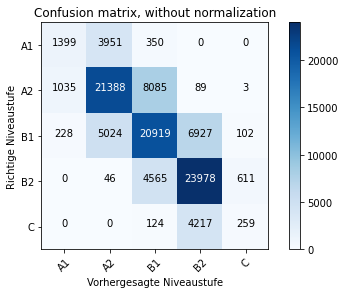

Normalized confusion matrix


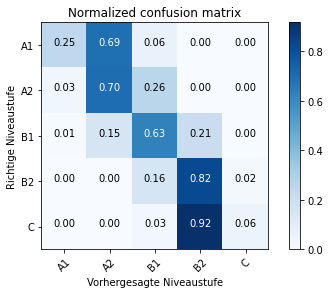

In [ ]:
##### text knn
great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])

for i in tqdm(range(100)):
  predicted_targets, true_targets, acc, kappa = evaluate_model(input_text, target,'knn')
  great_acc.append(acc)
  great_kappa.append(kappa)
  all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
  all_true_targets = np.append(all_true_targets, true_targets)

normal_knn = {'name': 'emb + GRU',
             'acc':mean(great_acc),
             'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             'qwk_std':stdev(great_kappa)}

plot_confusion_matrix(all_predicted_targets, all_true_targets)

##ungekürzte Texte

100%|██████████| 100/100 [5:05:35<00:00, 183.36s/it]


Confusion matrix, without normalization


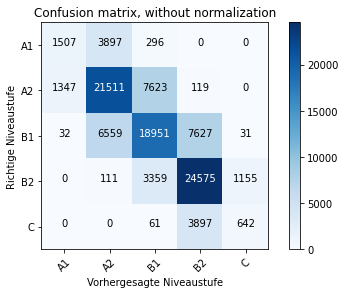

Normalized confusion matrix


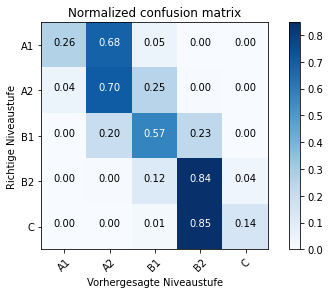

{'name': 'emb + GRU', 'acc': 65.03787341299477, 'acc_std': 0.8973622124667294, 'qwk': 0.7971174321849952, 'qwk_std': 0.006199956077679689}


In [ ]:
##### text knn
great_acc = []
great_kappa = []
all_predicted_targets = np.array([])
all_true_targets = np.array([])

for i in tqdm(range(100)):
  predicted_targets, true_targets, acc, kappa = evaluate_model(input_text_lang, target,'knn')
  great_acc.append(acc)
  great_kappa.append(kappa)
  all_predicted_targets= np.append(all_predicted_targets, predicted_targets)
  all_true_targets = np.append(all_true_targets, true_targets)

normal_knn = {'name': 'emb + GRU',
             'acc':mean(great_acc),
             'acc_std':stdev(great_acc),
             'qwk':mean(great_kappa),
             'qwk_std':stdev(great_kappa)}

plot_confusion_matrix(all_predicted_targets, all_true_targets)
print(normal_knn)

#Auswertung

In [ ]:
results = pd.DataFrame([svc, normal_knn] ,columns=['name','acc','acc_std','qwk', 'qwk_std'])
results.sort_values('qwk')

,name,acc,acc_std,qwk,qwk_std
1,emb + GRU,65.769203,0.897778,0.788570,0.006913
0,ling + svc,67.468260,NaN,0.803174,NaN


In [ ]:
results.to_excel('/content/drive/MyDrive/Masterarbeit/Data/4_best_model.xlsx', engine='xlsxwriter', index=False)  

#T-Test

In [ ]:
from scipy import stats

In [ ]:
t,p = stats.ttest_ind_from_stats(0.828,0.0,1,0.802,0.006,100)

In [ ]:
t

4.311827824243271

In [ ]:
p

3.831071012235606e-05